In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


Loaded 5270 images
Dataset type test label type: species


Loaded 43520 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 csroh3h4


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                               | 0/330 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                      | 1/330 [00:00<04:03,  1.35it/s]

  1%|▉                                                                                                                                                      | 2/330 [00:00<02:12,  2.47it/s]

  1%|█▎                                                                                                                                                     | 3/330 [00:01<01:37,  3.35it/s]

  1%|█▊                                                                                                                                                     | 4/330 [00:01<01:20,  4.03it/s]

  2%|██▎                                                                                                                                                    | 5/330 [00:01<01:11,  4.53it/s]

  2%|██▋                                                                                                                                                    | 6/330 [00:01<01:06,  4.90it/s]

  2%|███▏                                                                                                                                                   | 7/330 [00:01<01:02,  5.17it/s]

  2%|███▋                                                                                                                                                   | 8/330 [00:01<01:00,  5.36it/s]

  3%|████                                                                                                                                                   | 9/330 [00:02<00:58,  5.49it/s]

  3%|████▌                                                                                                                                                 | 10/330 [00:02<00:57,  5.58it/s]

  3%|█████                                                                                                                                                 | 11/330 [00:02<00:56,  5.65it/s]

  4%|█████▍                                                                                                                                                | 12/330 [00:02<00:55,  5.70it/s]

  4%|█████▉                                                                                                                                                | 13/330 [00:02<00:55,  5.74it/s]

  4%|██████▎                                                                                                                                               | 14/330 [00:02<00:54,  5.76it/s]

  5%|██████▊                                                                                                                                               | 15/330 [00:03<00:54,  5.78it/s]

  5%|███████▎                                                                                                                                              | 16/330 [00:03<00:54,  5.78it/s]

  5%|███████▋                                                                                                                                              | 17/330 [00:03<00:54,  5.80it/s]

  5%|████████▏                                                                                                                                             | 18/330 [00:03<00:53,  5.80it/s]

  6%|████████▋                                                                                                                                             | 19/330 [00:03<00:53,  5.81it/s]

  6%|█████████                                                                                                                                             | 20/330 [00:04<00:53,  5.81it/s]

  6%|█████████▌                                                                                                                                            | 21/330 [00:04<00:53,  5.82it/s]

  7%|██████████                                                                                                                                            | 22/330 [00:04<00:52,  5.82it/s]

  7%|██████████▍                                                                                                                                           | 23/330 [00:04<00:52,  5.81it/s]

  7%|██████████▉                                                                                                                                           | 24/330 [00:04<00:52,  5.81it/s]

  8%|███████████▎                                                                                                                                          | 25/330 [00:04<00:52,  5.80it/s]

  8%|███████████▊                                                                                                                                          | 26/330 [00:05<00:52,  5.80it/s]

  8%|████████████▎                                                                                                                                         | 27/330 [00:05<00:52,  5.80it/s]

  8%|████████████▋                                                                                                                                         | 28/330 [00:05<00:51,  5.81it/s]

  9%|█████████████▏                                                                                                                                        | 29/330 [00:05<00:51,  5.81it/s]

  9%|█████████████▋                                                                                                                                        | 30/330 [00:05<00:51,  5.81it/s]

  9%|██████████████                                                                                                                                        | 31/330 [00:05<00:51,  5.81it/s]

 10%|██████████████▌                                                                                                                                       | 32/330 [00:06<00:51,  5.81it/s]

 10%|███████████████                                                                                                                                       | 33/330 [00:06<00:51,  5.82it/s]

 10%|███████████████▍                                                                                                                                      | 34/330 [00:06<00:50,  5.82it/s]

 11%|███████████████▉                                                                                                                                      | 35/330 [00:06<00:50,  5.81it/s]

 11%|████████████████▎                                                                                                                                     | 36/330 [00:06<00:50,  5.80it/s]

 11%|████████████████▊                                                                                                                                     | 37/330 [00:06<00:50,  5.79it/s]

 12%|█████████████████▎                                                                                                                                    | 38/330 [00:07<00:50,  5.80it/s]

 12%|█████████████████▋                                                                                                                                    | 39/330 [00:07<00:50,  5.80it/s]

 12%|██████████████████▏                                                                                                                                   | 40/330 [00:07<00:49,  5.81it/s]

 12%|██████████████████▋                                                                                                                                   | 41/330 [00:07<00:49,  5.81it/s]

 13%|███████████████████                                                                                                                                   | 42/330 [00:07<00:49,  5.81it/s]

 13%|███████████████████▌                                                                                                                                  | 43/330 [00:07<00:49,  5.81it/s]

 13%|████████████████████                                                                                                                                  | 44/330 [00:08<00:49,  5.80it/s]

 14%|████████████████████▍                                                                                                                                 | 45/330 [00:08<00:49,  5.81it/s]

 14%|████████████████████▉                                                                                                                                 | 46/330 [00:08<00:48,  5.81it/s]

 14%|█████████████████████▎                                                                                                                                | 47/330 [00:08<00:48,  5.82it/s]

 15%|█████████████████████▊                                                                                                                                | 48/330 [00:08<00:48,  5.82it/s]

 15%|██████████████████████▎                                                                                                                               | 49/330 [00:08<00:48,  5.82it/s]

 15%|██████████████████████▋                                                                                                                               | 50/330 [00:09<00:48,  5.82it/s]

 15%|███████████████████████▏                                                                                                                              | 51/330 [00:09<00:47,  5.82it/s]

 16%|███████████████████████▋                                                                                                                              | 52/330 [00:09<00:47,  5.83it/s]

 16%|████████████████████████                                                                                                                              | 53/330 [00:09<00:47,  5.84it/s]

 16%|████████████████████████▌                                                                                                                             | 54/330 [00:09<00:47,  5.85it/s]

 17%|█████████████████████████                                                                                                                             | 55/330 [00:10<00:46,  5.86it/s]

 17%|█████████████████████████▍                                                                                                                            | 56/330 [00:10<00:46,  5.86it/s]

 17%|█████████████████████████▉                                                                                                                            | 57/330 [00:10<00:46,  5.86it/s]

 18%|██████████████████████████▎                                                                                                                           | 58/330 [00:10<00:46,  5.85it/s]

 18%|██████████████████████████▊                                                                                                                           | 59/330 [00:10<00:46,  5.84it/s]

 18%|███████████████████████████▎                                                                                                                          | 60/330 [00:10<00:46,  5.84it/s]

 18%|███████████████████████████▋                                                                                                                          | 61/330 [00:11<00:46,  5.83it/s]

 19%|████████████████████████████▏                                                                                                                         | 62/330 [00:11<00:45,  5.83it/s]

 19%|████████████████████████████▋                                                                                                                         | 63/330 [00:11<00:45,  5.81it/s]

 19%|█████████████████████████████                                                                                                                         | 64/330 [00:11<00:45,  5.82it/s]

 20%|█████████████████████████████▌                                                                                                                        | 65/330 [00:11<00:45,  5.81it/s]

 20%|██████████████████████████████                                                                                                                        | 66/330 [00:11<00:45,  5.82it/s]

 20%|██████████████████████████████▍                                                                                                                       | 67/330 [00:12<00:45,  5.81it/s]

 21%|██████████████████████████████▉                                                                                                                       | 68/330 [00:12<00:45,  5.81it/s]

 21%|███████████████████████████████▎                                                                                                                      | 69/330 [00:12<00:44,  5.82it/s]

 21%|███████████████████████████████▊                                                                                                                      | 70/330 [00:12<00:44,  5.82it/s]

 22%|████████████████████████████████▎                                                                                                                     | 71/330 [00:12<00:44,  5.81it/s]

 22%|████████████████████████████████▋                                                                                                                     | 72/330 [00:12<00:44,  5.79it/s]

 22%|█████████████████████████████████▏                                                                                                                    | 73/330 [00:13<00:44,  5.79it/s]

 22%|█████████████████████████████████▋                                                                                                                    | 74/330 [00:13<00:44,  5.79it/s]

 23%|██████████████████████████████████                                                                                                                    | 75/330 [00:13<00:43,  5.80it/s]

 23%|██████████████████████████████████▌                                                                                                                   | 76/330 [00:13<00:43,  5.80it/s]

 23%|███████████████████████████████████                                                                                                                   | 77/330 [00:13<00:43,  5.81it/s]

 24%|███████████████████████████████████▍                                                                                                                  | 78/330 [00:13<00:43,  5.81it/s]

 24%|███████████████████████████████████▉                                                                                                                  | 79/330 [00:14<00:43,  5.81it/s]

 24%|████████████████████████████████████▎                                                                                                                 | 80/330 [00:14<00:43,  5.81it/s]

 25%|████████████████████████████████████▊                                                                                                                 | 81/330 [00:14<00:42,  5.81it/s]

 25%|█████████████████████████████████████▎                                                                                                                | 82/330 [00:14<00:42,  5.82it/s]

 25%|█████████████████████████████████████▋                                                                                                                | 83/330 [00:14<00:42,  5.82it/s]

 25%|██████████████████████████████████████▏                                                                                                               | 84/330 [00:15<00:42,  5.82it/s]

 26%|██████████████████████████████████████▋                                                                                                               | 85/330 [00:15<00:42,  5.82it/s]

 26%|███████████████████████████████████████                                                                                                               | 86/330 [00:15<00:41,  5.82it/s]

 26%|███████████████████████████████████████▌                                                                                                              | 87/330 [00:15<00:41,  5.82it/s]

 27%|████████████████████████████████████████                                                                                                              | 88/330 [00:15<00:41,  5.82it/s]

 27%|████████████████████████████████████████▍                                                                                                             | 89/330 [00:15<00:41,  5.82it/s]

 27%|████████████████████████████████████████▉                                                                                                             | 90/330 [00:16<00:41,  5.82it/s]

 28%|█████████████████████████████████████████▎                                                                                                            | 91/330 [00:16<00:41,  5.82it/s]

 28%|█████████████████████████████████████████▊                                                                                                            | 92/330 [00:16<00:40,  5.82it/s]

 28%|██████████████████████████████████████████▎                                                                                                           | 93/330 [00:16<00:40,  5.82it/s]

 28%|██████████████████████████████████████████▋                                                                                                           | 94/330 [00:16<00:40,  5.82it/s]

 29%|███████████████████████████████████████████▏                                                                                                          | 95/330 [00:16<00:40,  5.82it/s]

 29%|███████████████████████████████████████████▋                                                                                                          | 96/330 [00:17<00:40,  5.82it/s]

 29%|████████████████████████████████████████████                                                                                                          | 97/330 [00:17<00:40,  5.82it/s]

 30%|████████████████████████████████████████████▌                                                                                                         | 98/330 [00:17<00:39,  5.82it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 99/330 [00:17<00:39,  5.82it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 100/330 [00:17<00:39,  5.81it/s]

 31%|█████████████████████████████████████████████▌                                                                                                       | 101/330 [00:17<00:39,  5.82it/s]

 31%|██████████████████████████████████████████████                                                                                                       | 102/330 [00:18<00:39,  5.82it/s]

 31%|██████████████████████████████████████████████▌                                                                                                      | 103/330 [00:18<00:38,  5.82it/s]

 32%|██████████████████████████████████████████████▉                                                                                                      | 104/330 [00:18<00:38,  5.82it/s]

 32%|███████████████████████████████████████████████▍                                                                                                     | 105/330 [00:18<00:38,  5.82it/s]

 32%|███████████████████████████████████████████████▊                                                                                                     | 106/330 [00:18<00:38,  5.82it/s]

 32%|████████████████████████████████████████████████▎                                                                                                    | 107/330 [00:18<00:38,  5.82it/s]

 33%|████████████████████████████████████████████████▊                                                                                                    | 108/330 [00:19<00:38,  5.84it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                   | 109/330 [00:19<00:37,  5.84it/s]

 33%|█████████████████████████████████████████████████▋                                                                                                   | 110/330 [00:19<00:37,  5.85it/s]

 34%|██████████████████████████████████████████████████                                                                                                   | 111/330 [00:19<00:37,  5.86it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                  | 112/330 [00:19<00:37,  5.86it/s]

 34%|███████████████████████████████████████████████████                                                                                                  | 113/330 [00:19<00:36,  5.87it/s]

 35%|███████████████████████████████████████████████████▍                                                                                                 | 114/330 [00:20<00:36,  5.86it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                 | 115/330 [00:20<00:36,  5.85it/s]

 35%|████████████████████████████████████████████████████▍                                                                                                | 116/330 [00:20<00:36,  5.84it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                | 117/330 [00:20<00:36,  5.83it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                               | 118/330 [00:20<00:36,  5.83it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                               | 119/330 [00:21<00:36,  5.81it/s]

 36%|██████████████████████████████████████████████████████▏                                                                                              | 120/330 [00:21<00:36,  5.81it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                              | 121/330 [00:21<00:36,  5.80it/s]

 37%|███████████████████████████████████████████████████████                                                                                              | 122/330 [00:21<00:35,  5.80it/s]

 37%|███████████████████████████████████████████████████████▌                                                                                             | 123/330 [00:21<00:35,  5.80it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                             | 124/330 [00:21<00:35,  5.80it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                            | 125/330 [00:22<00:35,  5.80it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                            | 126/330 [00:22<00:35,  5.81it/s]

 38%|█████████████████████████████████████████████████████████▎                                                                                           | 127/330 [00:22<00:34,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                           | 128/330 [00:22<00:34,  5.81it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                          | 129/330 [00:22<00:34,  5.82it/s]

 39%|██████████████████████████████████████████████████████████▋                                                                                          | 130/330 [00:22<00:34,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                         | 131/330 [00:23<00:34,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                         | 132/330 [00:23<00:34,  5.82it/s]

 40%|████████████████████████████████████████████████████████████                                                                                         | 133/330 [00:23<00:33,  5.82it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                        | 134/330 [00:23<00:33,  5.82it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                        | 135/330 [00:23<00:33,  5.81it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                       | 136/330 [00:23<00:33,  5.81it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                       | 137/330 [00:24<00:33,  5.81it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                      | 138/330 [00:24<00:33,  5.82it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                      | 139/330 [00:24<00:32,  5.82it/s]

 42%|███████████████████████████████████████████████████████████████▏                                                                                     | 140/330 [00:24<00:32,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                     | 141/330 [00:24<00:32,  5.82it/s]

 43%|████████████████████████████████████████████████████████████████                                                                                     | 142/330 [00:24<00:32,  5.81it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                    | 143/330 [00:25<00:32,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                    | 144/330 [00:25<00:31,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████▍                                                                                   | 145/330 [00:25<00:31,  5.81it/s]

 44%|█████████████████████████████████████████████████████████████████▉                                                                                   | 146/330 [00:25<00:31,  5.79it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                  | 147/330 [00:25<00:31,  5.80it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                  | 148/330 [00:26<00:31,  5.81it/s]

 45%|███████████████████████████████████████████████████████████████████▎                                                                                 | 149/330 [00:26<00:31,  5.81it/s]

 45%|███████████████████████████████████████████████████████████████████▋                                                                                 | 150/330 [00:26<00:30,  5.81it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                                | 151/330 [00:26<00:30,  5.82it/s]

 46%|████████████████████████████████████████████████████████████████████▋                                                                                | 152/330 [00:26<00:30,  5.82it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                | 153/330 [00:26<00:30,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                               | 154/330 [00:27<00:30,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▉                                                                               | 155/330 [00:27<00:30,  5.82it/s]

 47%|██████████████████████████████████████████████████████████████████████▍                                                                              | 156/330 [00:27<00:29,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                              | 157/330 [00:27<00:29,  5.82it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 158/330 [00:27<00:29,  5.82it/s]

 48%|███████████████████████████████████████████████████████████████████████▊                                                                             | 159/330 [00:27<00:29,  5.82it/s]

 48%|████████████████████████████████████████████████████████████████████████▏                                                                            | 160/330 [00:28<00:29,  5.82it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                            | 161/330 [00:28<00:29,  5.82it/s]

 49%|█████████████████████████████████████████████████████████████████████████▏                                                                           | 162/330 [00:28<00:28,  5.83it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 163/330 [00:28<00:28,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                           | 164/330 [00:28<00:28,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 165/330 [00:28<00:28,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████▉                                                                          | 166/330 [00:29<00:28,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                         | 167/330 [00:29<00:27,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▊                                                                         | 168/330 [00:29<00:27,  5.85it/s]

 51%|████████████████████████████████████████████████████████████████████████████▎                                                                        | 169/330 [00:29<00:27,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                        | 170/330 [00:29<00:27,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 171/330 [00:29<00:27,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                       | 172/330 [00:30<00:27,  5.83it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                       | 173/330 [00:30<00:26,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                      | 174/330 [00:30<00:26,  5.82it/s]

 53%|███████████████████████████████████████████████████████████████████████████████                                                                      | 175/330 [00:30<00:26,  5.82it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                     | 176/330 [00:30<00:26,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                     | 177/330 [00:30<00:26,  5.81it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▎                                                                    | 178/330 [00:31<00:26,  5.82it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                    | 179/330 [00:31<00:25,  5.82it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                   | 180/330 [00:31<00:25,  5.82it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▋                                                                   | 181/330 [00:31<00:25,  5.82it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▏                                                                  | 182/330 [00:31<00:25,  5.83it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                  | 183/330 [00:32<00:25,  5.83it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                  | 184/330 [00:32<00:25,  5.82it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▌                                                                 | 185/330 [00:32<00:24,  5.82it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                 | 186/330 [00:32<00:24,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                                | 187/330 [00:32<00:24,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▉                                                                | 188/330 [00:32<00:24,  5.82it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▎                                                               | 189/330 [00:33<00:24,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                               | 190/330 [00:33<00:24,  5.82it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                              | 191/330 [00:33<00:23,  5.82it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▋                                                              | 192/330 [00:33<00:23,  5.81it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                             | 193/330 [00:33<00:23,  5.81it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▌                                                             | 194/330 [00:33<00:23,  5.80it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████                                                             | 195/330 [00:34<00:23,  5.80it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 196/330 [00:34<00:23,  5.80it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 197/330 [00:34<00:22,  5.78it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 198/330 [00:34<00:22,  5.78it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 199/330 [00:34<00:22,  5.79it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 200/330 [00:34<00:22,  5.80it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 201/330 [00:35<00:22,  5.81it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 202/330 [00:35<00:22,  5.81it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 203/330 [00:35<00:21,  5.82it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████                                                         | 204/330 [00:35<00:21,  5.82it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 205/330 [00:35<00:21,  5.82it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                        | 206/330 [00:35<00:21,  5.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 207/330 [00:36<00:21,  5.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 208/330 [00:36<00:20,  5.81it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 209/330 [00:36<00:20,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 210/330 [00:36<00:20,  5.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 211/330 [00:36<00:20,  5.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 212/330 [00:37<00:20,  5.80it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 213/330 [00:37<00:20,  5.80it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 214/330 [00:37<00:19,  5.80it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 215/330 [00:37<00:19,  5.81it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 216/330 [00:37<00:19,  5.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 217/330 [00:37<00:19,  5.81it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 218/330 [00:38<00:19,  5.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 219/330 [00:38<00:19,  5.81it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 220/330 [00:38<00:18,  5.83it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 221/330 [00:38<00:18,  5.84it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 222/330 [00:38<00:18,  5.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 223/330 [00:38<00:18,  5.85it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 224/330 [00:39<00:18,  5.85it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 225/330 [00:39<00:17,  5.84it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 226/330 [00:39<00:17,  5.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 227/330 [00:39<00:17,  5.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 228/330 [00:39<00:17,  5.83it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 229/330 [00:39<00:17,  5.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 230/330 [00:40<00:17,  5.83it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 231/330 [00:40<00:16,  5.83it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 232/330 [00:40<00:16,  5.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 233/330 [00:40<00:16,  5.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 234/330 [00:40<00:16,  5.82it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 235/330 [00:40<00:16,  5.82it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 236/330 [00:41<00:16,  5.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 237/330 [00:41<00:15,  5.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/330 [00:41<00:15,  5.83it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 239/330 [00:41<00:15,  5.83it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 240/330 [00:41<00:15,  5.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 241/330 [00:41<00:15,  5.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 242/330 [00:42<00:15,  5.82it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 243/330 [00:42<00:14,  5.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 244/330 [00:42<00:14,  5.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 245/330 [00:42<00:14,  5.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 246/330 [00:42<00:14,  5.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 247/330 [00:43<00:14,  5.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 248/330 [00:43<00:14,  5.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 249/330 [00:43<00:13,  5.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 250/330 [00:43<00:13,  5.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 251/330 [00:43<00:13,  5.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 252/330 [00:43<00:13,  5.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 253/330 [00:44<00:13,  5.81it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 254/330 [00:44<00:13,  5.82it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 255/330 [00:44<00:12,  5.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 256/330 [00:44<00:12,  5.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 257/330 [00:44<00:12,  5.81it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 258/330 [00:44<00:12,  5.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 259/330 [00:45<00:12,  5.82it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 260/330 [00:45<00:12,  5.82it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 261/330 [00:45<00:11,  5.83it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 262/330 [00:45<00:11,  5.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 263/330 [00:45<00:11,  5.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 264/330 [00:45<00:11,  5.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 265/330 [00:46<00:11,  5.83it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 266/330 [00:46<00:10,  5.83it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 267/330 [00:46<00:10,  5.83it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 268/330 [00:46<00:10,  5.83it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 269/330 [00:46<00:10,  5.83it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 270/330 [00:46<00:10,  5.83it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 271/330 [00:47<00:10,  5.83it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 272/330 [00:47<00:09,  5.83it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 273/330 [00:47<00:09,  5.83it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 274/330 [00:47<00:09,  5.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 275/330 [00:47<00:09,  5.83it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 276/330 [00:47<00:09,  5.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 277/330 [00:48<00:09,  5.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 278/330 [00:48<00:08,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 279/330 [00:48<00:08,  5.81it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 280/330 [00:48<00:08,  5.81it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 281/330 [00:48<00:08,  5.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 282/330 [00:49<00:08,  5.80it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 283/330 [00:49<00:08,  5.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 284/330 [00:49<00:07,  5.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 285/330 [00:49<00:07,  5.81it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 286/330 [00:49<00:07,  5.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 287/330 [00:49<00:07,  5.84it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 288/330 [00:50<00:07,  5.85it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 289/330 [00:50<00:06,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 290/330 [00:50<00:06,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 291/330 [00:50<00:06,  5.84it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 292/330 [00:50<00:06,  5.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 293/330 [00:50<00:06,  5.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 294/330 [00:51<00:06,  5.83it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 295/330 [00:51<00:06,  5.83it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 296/330 [00:51<00:05,  5.83it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 297/330 [00:51<00:05,  5.81it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 298/330 [00:51<00:05,  5.81it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 299/330 [00:51<00:05,  5.81it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 300/330 [00:52<00:05,  5.81it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 301/330 [00:52<00:04,  5.81it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 302/330 [00:52<00:04,  5.81it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 303/330 [00:52<00:04,  5.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 304/330 [00:52<00:04,  5.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 305/330 [00:52<00:04,  5.81it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 306/330 [00:53<00:04,  5.81it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 307/330 [00:53<00:03,  5.81it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 308/330 [00:53<00:03,  5.81it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 309/330 [00:53<00:03,  5.82it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 310/330 [00:53<00:03,  5.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 311/330 [00:54<00:03,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 312/330 [00:54<00:03,  5.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 313/330 [00:54<00:02,  5.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 314/330 [00:54<00:02,  5.83it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 315/330 [00:54<00:02,  5.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 316/330 [00:54<00:02,  5.83it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 317/330 [00:55<00:02,  5.82it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 318/330 [00:55<00:02,  5.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 319/330 [00:55<00:01,  5.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 320/330 [00:55<00:01,  5.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 321/330 [00:55<00:01,  5.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 322/330 [00:55<00:01,  5.81it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 323/330 [00:56<00:01,  5.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 324/330 [00:56<00:01,  5.82it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 325/330 [00:56<00:00,  5.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 326/330 [00:56<00:00,  5.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 327/330 [00:56<00:00,  5.83it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 328/330 [00:56<00:00,  5.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 329/330 [00:57<00:00,  5.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:57<00:00,  5.77it/s]

train - OK


  0%|                                                                                                                                                                | 0/42 [00:00<?, ?it/s]

  2%|███▌                                                                                                                                                    | 1/42 [00:00<00:13,  3.02it/s]

  5%|███████▏                                                                                                                                                | 2/42 [00:00<00:09,  4.20it/s]

  7%|██████████▊                                                                                                                                             | 3/42 [00:00<00:08,  4.82it/s]

 10%|██████████████▍                                                                                                                                         | 4/42 [00:00<00:07,  5.17it/s]

 12%|██████████████████                                                                                                                                      | 5/42 [00:01<00:06,  5.39it/s]

 14%|█████████████████████▋                                                                                                                                  | 6/42 [00:01<00:06,  5.53it/s]

 17%|█████████████████████████▎                                                                                                                              | 7/42 [00:01<00:06,  5.63it/s]

 19%|████████████████████████████▉                                                                                                                           | 8/42 [00:01<00:05,  5.68it/s]

 21%|████████████████████████████████▌                                                                                                                       | 9/42 [00:01<00:05,  5.73it/s]

 24%|███████████████████████████████████▉                                                                                                                   | 10/42 [00:01<00:05,  5.76it/s]

 26%|███████████████████████████████████████▌                                                                                                               | 11/42 [00:02<00:05,  5.78it/s]

 29%|███████████████████████████████████████████▏                                                                                                           | 12/42 [00:02<00:05,  5.79it/s]

 31%|██████████████████████████████████████████████▋                                                                                                        | 13/42 [00:02<00:05,  5.79it/s]

 33%|██████████████████████████████████████████████████▎                                                                                                    | 14/42 [00:02<00:04,  5.79it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                                 | 15/42 [00:02<00:04,  5.78it/s]

 38%|█████████████████████████████████████████████████████████▌                                                                                             | 16/42 [00:02<00:04,  5.79it/s]

 40%|█████████████████████████████████████████████████████████████                                                                                          | 17/42 [00:03<00:04,  5.79it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                      | 18/42 [00:03<00:04,  5.79it/s]

 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 19/42 [00:03<00:03,  5.80it/s]

 48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 20/42 [00:03<00:03,  5.80it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 21/42 [00:03<00:03,  5.80it/s]

 52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 22/42 [00:03<00:03,  5.80it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 23/42 [00:04<00:03,  5.80it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 24/42 [00:04<00:03,  5.80it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 25/42 [00:04<00:02,  5.80it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 26/42 [00:04<00:02,  5.80it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 27/42 [00:04<00:02,  5.80it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 28/42 [00:04<00:02,  5.80it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 29/42 [00:05<00:02,  5.79it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 30/42 [00:05<00:02,  5.79it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 31/42 [00:05<00:01,  5.78it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 32/42 [00:05<00:01,  5.78it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 33/42 [00:05<00:01,  5.78it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 34/42 [00:06<00:01,  5.78it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 35/42 [00:06<00:01,  5.79it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 36/42 [00:06<00:01,  5.79it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 37/42 [00:06<00:00,  5.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 38/42 [00:06<00:00,  5.80it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 39/42 [00:06<00:00,  5.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 40/42 [00:07<00:00,  5.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 41/42 [00:07<00:00,  5.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.71it/s]

val - OK


  0%|                                                                                                                                                                | 0/42 [00:00<?, ?it/s]

  2%|███▌                                                                                                                                                    | 1/42 [00:00<00:13,  2.94it/s]

  5%|███████▏                                                                                                                                                | 2/42 [00:00<00:09,  4.15it/s]

  7%|██████████▊                                                                                                                                             | 3/42 [00:00<00:08,  4.77it/s]

 10%|██████████████▍                                                                                                                                         | 4/42 [00:00<00:07,  5.14it/s]

 12%|██████████████████                                                                                                                                      | 5/42 [00:01<00:06,  5.37it/s]

 14%|█████████████████████▋                                                                                                                                  | 6/42 [00:01<00:06,  5.51it/s]

 17%|█████████████████████████▎                                                                                                                              | 7/42 [00:01<00:06,  5.61it/s]

 19%|████████████████████████████▉                                                                                                                           | 8/42 [00:01<00:06,  5.67it/s]

 21%|████████████████████████████████▌                                                                                                                       | 9/42 [00:01<00:05,  5.72it/s]

 24%|███████████████████████████████████▉                                                                                                                   | 10/42 [00:01<00:05,  5.75it/s]

 26%|███████████████████████████████████████▌                                                                                                               | 11/42 [00:02<00:05,  5.78it/s]

 29%|███████████████████████████████████████████▏                                                                                                           | 12/42 [00:02<00:05,  5.78it/s]

 31%|██████████████████████████████████████████████▋                                                                                                        | 13/42 [00:02<00:05,  5.79it/s]

 33%|██████████████████████████████████████████████████▎                                                                                                    | 14/42 [00:02<00:04,  5.79it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                                 | 15/42 [00:02<00:04,  5.79it/s]

 38%|█████████████████████████████████████████████████████████▌                                                                                             | 16/42 [00:02<00:04,  5.79it/s]

 40%|█████████████████████████████████████████████████████████████                                                                                          | 17/42 [00:03<00:04,  5.80it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                      | 18/42 [00:03<00:04,  5.80it/s]

 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 19/42 [00:03<00:03,  5.80it/s]

 48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 20/42 [00:03<00:03,  5.80it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 21/42 [00:03<00:03,  5.81it/s]

 52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 22/42 [00:03<00:03,  5.80it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 23/42 [00:04<00:03,  5.82it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 24/42 [00:04<00:03,  5.83it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 25/42 [00:04<00:02,  5.84it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 26/42 [00:04<00:02,  5.85it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 27/42 [00:04<00:02,  5.85it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 28/42 [00:04<00:02,  5.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 29/42 [00:05<00:02,  5.84it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 30/42 [00:05<00:02,  5.83it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 31/42 [00:05<00:01,  5.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 32/42 [00:05<00:01,  5.82it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 33/42 [00:05<00:01,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 34/42 [00:06<00:01,  5.81it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 35/42 [00:06<00:01,  5.81it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 36/42 [00:06<00:01,  5.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 37/42 [00:06<00:00,  5.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 38/42 [00:06<00:00,  5.80it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 39/42 [00:06<00:00,  5.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 40/42 [00:07<00:00,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 41/42 [00:07<00:00,  5.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.71it/s]

test InD - OK


  0%|                                                                                                                                                               | 0/340 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                      | 1/340 [00:00<01:58,  2.87it/s]

  1%|▉                                                                                                                                                      | 2/340 [00:00<01:22,  4.09it/s]

  1%|█▎                                                                                                                                                     | 3/340 [00:00<01:11,  4.73it/s]

  1%|█▊                                                                                                                                                     | 4/340 [00:00<01:05,  5.11it/s]

  1%|██▏                                                                                                                                                    | 5/340 [00:01<01:02,  5.34it/s]

  2%|██▋                                                                                                                                                    | 6/340 [00:01<01:00,  5.50it/s]

  2%|███                                                                                                                                                    | 7/340 [00:01<00:59,  5.60it/s]

  2%|███▌                                                                                                                                                   | 8/340 [00:01<00:58,  5.67it/s]

  3%|███▉                                                                                                                                                   | 9/340 [00:01<00:57,  5.71it/s]

  3%|████▍                                                                                                                                                 | 10/340 [00:01<00:57,  5.75it/s]

  3%|████▊                                                                                                                                                 | 11/340 [00:02<00:57,  5.77it/s]

  4%|█████▎                                                                                                                                                | 12/340 [00:02<00:56,  5.79it/s]

  4%|█████▋                                                                                                                                                | 13/340 [00:02<00:56,  5.80it/s]

  4%|██████▏                                                                                                                                               | 14/340 [00:02<00:56,  5.82it/s]

  4%|██████▌                                                                                                                                               | 15/340 [00:02<00:55,  5.82it/s]

  5%|███████                                                                                                                                               | 16/340 [00:02<00:55,  5.82it/s]

  5%|███████▌                                                                                                                                              | 17/340 [00:03<00:55,  5.83it/s]

  5%|███████▉                                                                                                                                              | 18/340 [00:03<00:55,  5.83it/s]

  6%|████████▍                                                                                                                                             | 19/340 [00:03<00:54,  5.84it/s]

  6%|████████▊                                                                                                                                             | 20/340 [00:03<00:54,  5.83it/s]

  6%|█████████▎                                                                                                                                            | 21/340 [00:03<00:54,  5.83it/s]

  6%|█████████▋                                                                                                                                            | 22/340 [00:03<00:54,  5.81it/s]

  7%|██████████▏                                                                                                                                           | 23/340 [00:04<00:54,  5.82it/s]

  7%|██████████▌                                                                                                                                           | 24/340 [00:04<00:54,  5.82it/s]

  7%|███████████                                                                                                                                           | 25/340 [00:04<00:54,  5.82it/s]

  8%|███████████▍                                                                                                                                          | 26/340 [00:04<00:53,  5.82it/s]

  8%|███████████▉                                                                                                                                          | 27/340 [00:04<00:53,  5.82it/s]

  8%|████████████▎                                                                                                                                         | 28/340 [00:04<00:53,  5.82it/s]

  9%|████████████▊                                                                                                                                         | 29/340 [00:05<00:53,  5.81it/s]

  9%|█████████████▏                                                                                                                                        | 30/340 [00:05<00:53,  5.82it/s]

  9%|█████████████▋                                                                                                                                        | 31/340 [00:05<00:53,  5.82it/s]

  9%|██████████████                                                                                                                                        | 32/340 [00:05<00:52,  5.82it/s]

 10%|██████████████▌                                                                                                                                       | 33/340 [00:05<00:52,  5.82it/s]

 10%|███████████████                                                                                                                                       | 34/340 [00:06<00:52,  5.80it/s]

 10%|███████████████▍                                                                                                                                      | 35/340 [00:06<00:52,  5.80it/s]

 11%|███████████████▉                                                                                                                                      | 36/340 [00:06<00:52,  5.79it/s]

 11%|████████████████▎                                                                                                                                     | 37/340 [00:06<00:52,  5.80it/s]

 11%|████████████████▊                                                                                                                                     | 38/340 [00:06<00:52,  5.80it/s]

 11%|█████████████████▏                                                                                                                                    | 39/340 [00:06<00:51,  5.81it/s]

 12%|█████████████████▋                                                                                                                                    | 40/340 [00:07<00:51,  5.81it/s]

 12%|██████████████████                                                                                                                                    | 41/340 [00:07<00:51,  5.81it/s]

 12%|██████████████████▌                                                                                                                                   | 42/340 [00:07<00:51,  5.81it/s]

 13%|██████████████████▉                                                                                                                                   | 43/340 [00:07<00:51,  5.79it/s]

 13%|███████████████████▍                                                                                                                                  | 44/340 [00:07<00:51,  5.79it/s]

 13%|███████████████████▊                                                                                                                                  | 45/340 [00:07<00:50,  5.79it/s]

 14%|████████████████████▎                                                                                                                                 | 46/340 [00:08<00:50,  5.80it/s]

 14%|████████████████████▋                                                                                                                                 | 47/340 [00:08<00:50,  5.81it/s]

 14%|█████████████████████▏                                                                                                                                | 48/340 [00:08<00:50,  5.81it/s]

 14%|█████████████████████▌                                                                                                                                | 49/340 [00:08<00:50,  5.81it/s]

 15%|██████████████████████                                                                                                                                | 50/340 [00:08<00:49,  5.80it/s]

 15%|██████████████████████▌                                                                                                                               | 51/340 [00:08<00:49,  5.80it/s]

 15%|██████████████████████▉                                                                                                                               | 52/340 [00:09<00:49,  5.80it/s]

 16%|███████████████████████▍                                                                                                                              | 53/340 [00:09<00:49,  5.80it/s]

 16%|███████████████████████▊                                                                                                                              | 54/340 [00:09<00:49,  5.81it/s]

 16%|████████████████████████▎                                                                                                                             | 55/340 [00:09<00:49,  5.81it/s]

 16%|████████████████████████▋                                                                                                                             | 56/340 [00:09<00:48,  5.81it/s]

 17%|█████████████████████████▏                                                                                                                            | 57/340 [00:09<00:48,  5.80it/s]

 17%|█████████████████████████▌                                                                                                                            | 58/340 [00:10<00:48,  5.82it/s]

 17%|██████████████████████████                                                                                                                            | 59/340 [00:10<00:48,  5.83it/s]

 18%|██████████████████████████▍                                                                                                                           | 60/340 [00:10<00:47,  5.84it/s]

 18%|██████████████████████████▉                                                                                                                           | 61/340 [00:10<00:47,  5.84it/s]

 18%|███████████████████████████▎                                                                                                                          | 62/340 [00:10<00:47,  5.84it/s]

 19%|███████████████████████████▊                                                                                                                          | 63/340 [00:11<00:47,  5.85it/s]

 19%|████████████████████████████▏                                                                                                                         | 64/340 [00:11<00:47,  5.84it/s]

 19%|████████████████████████████▋                                                                                                                         | 65/340 [00:11<00:47,  5.83it/s]

 19%|█████████████████████████████                                                                                                                         | 66/340 [00:11<00:47,  5.82it/s]

 20%|█████████████████████████████▌                                                                                                                        | 67/340 [00:11<00:46,  5.82it/s]

 20%|██████████████████████████████                                                                                                                        | 68/340 [00:11<00:46,  5.81it/s]

 20%|██████████████████████████████▍                                                                                                                       | 69/340 [00:12<00:46,  5.81it/s]

 21%|██████████████████████████████▉                                                                                                                       | 70/340 [00:12<00:46,  5.81it/s]

 21%|███████████████████████████████▎                                                                                                                      | 71/340 [00:12<00:46,  5.80it/s]

 21%|███████████████████████████████▊                                                                                                                      | 72/340 [00:12<00:46,  5.81it/s]

 21%|████████████████████████████████▏                                                                                                                     | 73/340 [00:12<00:45,  5.81it/s]

 22%|████████████████████████████████▋                                                                                                                     | 74/340 [00:12<00:45,  5.81it/s]

 22%|█████████████████████████████████                                                                                                                     | 75/340 [00:13<00:45,  5.81it/s]

 22%|█████████████████████████████████▌                                                                                                                    | 76/340 [00:13<00:45,  5.81it/s]

 23%|█████████████████████████████████▉                                                                                                                    | 77/340 [00:13<00:45,  5.81it/s]

 23%|██████████████████████████████████▍                                                                                                                   | 78/340 [00:13<00:45,  5.81it/s]

 23%|██████████████████████████████████▊                                                                                                                   | 79/340 [00:13<00:44,  5.82it/s]

 24%|███████████████████████████████████▎                                                                                                                  | 80/340 [00:13<00:44,  5.82it/s]

 24%|███████████████████████████████████▋                                                                                                                  | 81/340 [00:14<00:44,  5.83it/s]

 24%|████████████████████████████████████▏                                                                                                                 | 82/340 [00:14<00:44,  5.83it/s]

 24%|████████████████████████████████████▌                                                                                                                 | 83/340 [00:14<00:44,  5.83it/s]

 25%|█████████████████████████████████████                                                                                                                 | 84/340 [00:14<00:43,  5.84it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 85/340 [00:14<00:43,  5.83it/s]

 25%|█████████████████████████████████████▉                                                                                                                | 86/340 [00:14<00:43,  5.83it/s]

 26%|██████████████████████████████████████▍                                                                                                               | 87/340 [00:15<00:43,  5.83it/s]

 26%|██████████████████████████████████████▊                                                                                                               | 88/340 [00:15<00:43,  5.83it/s]

 26%|███████████████████████████████████████▎                                                                                                              | 89/340 [00:15<00:43,  5.82it/s]

 26%|███████████████████████████████████████▋                                                                                                              | 90/340 [00:15<00:42,  5.82it/s]

 27%|████████████████████████████████████████▏                                                                                                             | 91/340 [00:15<00:42,  5.82it/s]

 27%|████████████████████████████████████████▌                                                                                                             | 92/340 [00:15<00:42,  5.82it/s]

 27%|█████████████████████████████████████████                                                                                                             | 93/340 [00:16<00:42,  5.82it/s]

 28%|█████████████████████████████████████████▍                                                                                                            | 94/340 [00:16<00:42,  5.82it/s]

 28%|█████████████████████████████████████████▉                                                                                                            | 95/340 [00:16<00:42,  5.83it/s]

 28%|██████████████████████████████████████████▎                                                                                                           | 96/340 [00:16<00:41,  5.83it/s]

 29%|██████████████████████████████████████████▊                                                                                                           | 97/340 [00:16<00:41,  5.83it/s]

 29%|███████████████████████████████████████████▏                                                                                                          | 98/340 [00:17<00:41,  5.83it/s]

 29%|███████████████████████████████████████████▋                                                                                                          | 99/340 [00:17<00:41,  5.83it/s]

 29%|███████████████████████████████████████████▊                                                                                                         | 100/340 [00:17<00:41,  5.83it/s]

 30%|████████████████████████████████████████████▎                                                                                                        | 101/340 [00:17<00:41,  5.83it/s]

 30%|████████████████████████████████████████████▋                                                                                                        | 102/340 [00:17<00:40,  5.82it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 103/340 [00:17<00:40,  5.83it/s]

 31%|█████████████████████████████████████████████▌                                                                                                       | 104/340 [00:18<00:40,  5.83it/s]

 31%|██████████████████████████████████████████████                                                                                                       | 105/340 [00:18<00:40,  5.82it/s]

 31%|██████████████████████████████████████████████▍                                                                                                      | 106/340 [00:18<00:40,  5.82it/s]

 31%|██████████████████████████████████████████████▉                                                                                                      | 107/340 [00:18<00:40,  5.82it/s]

 32%|███████████████████████████████████████████████▎                                                                                                     | 108/340 [00:18<00:39,  5.82it/s]

 32%|███████████████████████████████████████████████▊                                                                                                     | 109/340 [00:18<00:39,  5.82it/s]

 32%|████████████████████████████████████████████████▏                                                                                                    | 110/340 [00:19<00:39,  5.82it/s]

 33%|████████████████████████████████████████████████▋                                                                                                    | 111/340 [00:19<00:39,  5.82it/s]

 33%|█████████████████████████████████████████████████                                                                                                    | 112/340 [00:19<00:39,  5.83it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                   | 113/340 [00:19<00:38,  5.82it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                   | 114/340 [00:19<00:38,  5.84it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                  | 115/340 [00:19<00:38,  5.84it/s]

 34%|██████████████████████████████████████████████████▊                                                                                                  | 116/340 [00:20<00:38,  5.85it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                 | 117/340 [00:20<00:38,  5.86it/s]

 35%|███████████████████████████████████████████████████▋                                                                                                 | 118/340 [00:20<00:37,  5.86it/s]

 35%|████████████████████████████████████████████████████▏                                                                                                | 119/340 [00:20<00:37,  5.86it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                | 120/340 [00:20<00:37,  5.85it/s]

 36%|█████████████████████████████████████████████████████                                                                                                | 121/340 [00:20<00:37,  5.84it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                               | 122/340 [00:21<00:37,  5.84it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                               | 123/340 [00:21<00:37,  5.84it/s]

 36%|██████████████████████████████████████████████████████▎                                                                                              | 124/340 [00:21<00:37,  5.84it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                              | 125/340 [00:21<00:36,  5.83it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                             | 126/340 [00:21<00:36,  5.83it/s]

 37%|███████████████████████████████████████████████████████▋                                                                                             | 127/340 [00:21<00:36,  5.83it/s]

 38%|████████████████████████████████████████████████████████                                                                                             | 128/340 [00:22<00:36,  5.84it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                            | 129/340 [00:22<00:36,  5.83it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                            | 130/340 [00:22<00:35,  5.84it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                           | 131/340 [00:22<00:35,  5.84it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                           | 132/340 [00:22<00:35,  5.84it/s]

 39%|██████████████████████████████████████████████████████████▎                                                                                          | 133/340 [00:23<00:35,  5.83it/s]

 39%|██████████████████████████████████████████████████████████▋                                                                                          | 134/340 [00:23<00:35,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                         | 135/340 [00:23<00:35,  5.81it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                         | 136/340 [00:23<00:35,  5.81it/s]

 40%|████████████████████████████████████████████████████████████                                                                                         | 137/340 [00:23<00:34,  5.80it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                        | 138/340 [00:23<00:34,  5.80it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                        | 139/340 [00:24<00:34,  5.80it/s]

 41%|█████████████████████████████████████████████████████████████▎                                                                                       | 140/340 [00:24<00:34,  5.80it/s]

 41%|█████████████████████████████████████████████████████████████▊                                                                                       | 141/340 [00:24<00:34,  5.78it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                      | 142/340 [00:24<00:34,  5.78it/s]

 42%|██████████████████████████████████████████████████████████████▋                                                                                      | 143/340 [00:24<00:34,  5.79it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                      | 144/340 [00:24<00:33,  5.80it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                     | 145/340 [00:25<00:33,  5.80it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                     | 146/340 [00:25<00:33,  5.80it/s]

 43%|████████████████████████████████████████████████████████████████▍                                                                                    | 147/340 [00:25<00:33,  5.80it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                    | 148/340 [00:25<00:33,  5.80it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                   | 149/340 [00:25<00:32,  5.80it/s]

 44%|█████████████████████████████████████████████████████████████████▋                                                                                   | 150/340 [00:25<00:32,  5.81it/s]

 44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 151/340 [00:26<00:32,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                  | 152/340 [00:26<00:32,  5.82it/s]

 45%|███████████████████████████████████████████████████████████████████                                                                                  | 153/340 [00:26<00:32,  5.82it/s]

 45%|███████████████████████████████████████████████████████████████████▍                                                                                 | 154/340 [00:26<00:31,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                                 | 155/340 [00:26<00:31,  5.81it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                                | 156/340 [00:26<00:31,  5.81it/s]

 46%|████████████████████████████████████████████████████████████████████▊                                                                                | 157/340 [00:27<00:31,  5.81it/s]

 46%|█████████████████████████████████████████████████████████████████████▏                                                                               | 158/340 [00:27<00:31,  5.81it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                               | 159/340 [00:27<00:31,  5.80it/s]

 47%|██████████████████████████████████████████████████████████████████████                                                                               | 160/340 [00:27<00:31,  5.79it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                              | 161/340 [00:27<00:30,  5.79it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                              | 162/340 [00:28<00:30,  5.80it/s]

 48%|███████████████████████████████████████████████████████████████████████▍                                                                             | 163/340 [00:28<00:30,  5.81it/s]

 48%|███████████████████████████████████████████████████████████████████████▊                                                                             | 164/340 [00:28<00:30,  5.81it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                            | 165/340 [00:28<00:30,  5.81it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                            | 166/340 [00:28<00:29,  5.81it/s]

 49%|█████████████████████████████████████████████████████████████████████████▏                                                                           | 167/340 [00:28<00:29,  5.82it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 168/340 [00:29<00:29,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                           | 169/340 [00:29<00:29,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 170/340 [00:29<00:29,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████████▉                                                                          | 171/340 [00:29<00:28,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                         | 172/340 [00:29<00:28,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▊                                                                         | 173/340 [00:29<00:28,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████████▎                                                                        | 174/340 [00:30<00:28,  5.87it/s]

 51%|████████████████████████████████████████████████████████████████████████████▋                                                                        | 175/340 [00:30<00:28,  5.88it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 176/340 [00:30<00:27,  5.87it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                       | 177/340 [00:30<00:27,  5.86it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                       | 178/340 [00:30<00:27,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                      | 179/340 [00:30<00:27,  5.85it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                      | 180/340 [00:31<00:27,  5.85it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                     | 181/340 [00:31<00:27,  5.85it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                     | 182/340 [00:31<00:27,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▏                                                                    | 183/340 [00:31<00:26,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▋                                                                    | 184/340 [00:31<00:26,  5.84it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                    | 185/340 [00:31<00:26,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                   | 186/340 [00:32<00:26,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                   | 187/340 [00:32<00:26,  5.84it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                  | 188/340 [00:32<00:26,  5.84it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 189/340 [00:32<00:25,  5.84it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                 | 190/340 [00:32<00:25,  5.83it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▋                                                                 | 191/340 [00:32<00:25,  5.83it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▏                                                                | 192/340 [00:33<00:25,  5.84it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                                | 193/340 [00:33<00:25,  5.83it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                                | 194/340 [00:33<00:25,  5.82it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                               | 195/340 [00:33<00:24,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                               | 196/340 [00:33<00:24,  5.83it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                              | 197/340 [00:34<00:24,  5.83it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▊                                                              | 198/340 [00:34<00:24,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                             | 199/340 [00:34<00:24,  5.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▋                                                             | 200/340 [00:34<00:23,  5.85it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████                                                             | 201/340 [00:34<00:23,  5.84it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 202/340 [00:34<00:23,  5.84it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 203/340 [00:35<00:23,  5.83it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 204/340 [00:35<00:23,  5.82it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 205/340 [00:35<00:23,  5.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 206/340 [00:35<00:23,  5.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 207/340 [00:35<00:22,  5.82it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 208/340 [00:35<00:22,  5.82it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 209/340 [00:36<00:22,  5.82it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████                                                         | 210/340 [00:36<00:22,  5.82it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 211/340 [00:36<00:22,  5.81it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 212/340 [00:36<00:22,  5.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 213/340 [00:36<00:21,  5.81it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 214/340 [00:36<00:21,  5.80it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 215/340 [00:37<00:21,  5.80it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 216/340 [00:37<00:21,  5.80it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████                                                      | 217/340 [00:37<00:21,  5.80it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 218/340 [00:37<00:21,  5.80it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 219/340 [00:37<00:20,  5.81it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 220/340 [00:37<00:20,  5.81it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 221/340 [00:38<00:20,  5.81it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 222/340 [00:38<00:20,  5.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 223/340 [00:38<00:20,  5.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 224/340 [00:38<00:19,  5.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 225/340 [00:38<00:19,  5.82it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 226/340 [00:38<00:19,  5.83it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 227/340 [00:39<00:19,  5.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 228/340 [00:39<00:19,  5.85it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 229/340 [00:39<00:18,  5.86it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 230/340 [00:39<00:18,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 231/340 [00:39<00:18,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 232/340 [00:40<00:18,  5.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 233/340 [00:40<00:18,  5.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 234/340 [00:40<00:18,  5.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 235/340 [00:40<00:18,  5.83it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 236/340 [00:40<00:17,  5.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 237/340 [00:40<00:17,  5.82it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 238/340 [00:41<00:17,  5.82it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 239/340 [00:41<00:17,  5.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 240/340 [00:41<00:17,  5.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 241/340 [00:41<00:17,  5.81it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 242/340 [00:41<00:16,  5.81it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 243/340 [00:41<00:16,  5.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 244/340 [00:42<00:16,  5.81it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 245/340 [00:42<00:16,  5.81it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 246/340 [00:42<00:16,  5.80it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 247/340 [00:42<00:16,  5.80it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 248/340 [00:42<00:15,  5.81it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 249/340 [00:42<00:15,  5.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 250/340 [00:43<00:15,  5.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 251/340 [00:43<00:15,  5.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 252/340 [00:43<00:15,  5.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 253/340 [00:43<00:14,  5.81it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 254/340 [00:43<00:14,  5.81it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 255/340 [00:43<00:14,  5.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 256/340 [00:44<00:14,  5.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 257/340 [00:44<00:14,  5.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 258/340 [00:44<00:14,  5.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 259/340 [00:44<00:13,  5.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 260/340 [00:44<00:13,  5.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 261/340 [00:45<00:13,  5.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 262/340 [00:45<00:13,  5.82it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 263/340 [00:45<00:13,  5.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 264/340 [00:45<00:13,  5.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 265/340 [00:45<00:12,  5.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 266/340 [00:45<00:12,  5.82it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 267/340 [00:46<00:12,  5.82it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 268/340 [00:46<00:12,  5.82it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 269/340 [00:46<00:12,  5.81it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 270/340 [00:46<00:12,  5.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 271/340 [00:46<00:11,  5.81it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 272/340 [00:46<00:11,  5.81it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 273/340 [00:47<00:11,  5.81it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 274/340 [00:47<00:11,  5.81it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 275/340 [00:47<00:11,  5.81it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 276/340 [00:47<00:11,  5.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 277/340 [00:47<00:10,  5.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 278/340 [00:47<00:10,  5.82it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 279/340 [00:48<00:10,  5.82it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 280/340 [00:48<00:10,  5.82it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 281/340 [00:48<00:10,  5.82it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 282/340 [00:48<00:09,  5.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 283/340 [00:48<00:09,  5.82it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 284/340 [00:48<00:09,  5.82it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 285/340 [00:49<00:09,  5.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 286/340 [00:49<00:09,  5.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 287/340 [00:49<00:09,  5.81it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 288/340 [00:49<00:08,  5.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 289/340 [00:49<00:08,  5.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 290/340 [00:49<00:08,  5.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 291/340 [00:50<00:08,  5.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 292/340 [00:50<00:08,  5.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 293/340 [00:50<00:08,  5.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 294/340 [00:50<00:07,  5.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 295/340 [00:50<00:07,  5.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 296/340 [00:51<00:07,  5.82it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 297/340 [00:51<00:07,  5.82it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 298/340 [00:51<00:07,  5.83it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 299/340 [00:51<00:07,  5.82it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 300/340 [00:51<00:06,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 301/340 [00:51<00:06,  5.82it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 302/340 [00:52<00:06,  5.82it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 303/340 [00:52<00:06,  5.81it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 304/340 [00:52<00:06,  5.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 305/340 [00:52<00:06,  5.79it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 306/340 [00:52<00:05,  5.80it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 307/340 [00:52<00:05,  5.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 308/340 [00:53<00:05,  5.80it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 309/340 [00:53<00:05,  5.80it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 310/340 [00:53<00:05,  5.80it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 311/340 [00:53<00:04,  5.80it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 312/340 [00:53<00:04,  5.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 313/340 [00:53<00:04,  5.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 314/340 [00:54<00:04,  5.81it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 315/340 [00:54<00:04,  5.81it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 316/340 [00:54<00:04,  5.81it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 317/340 [00:54<00:03,  5.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 318/340 [00:54<00:03,  5.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 319/340 [00:54<00:03,  5.81it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 320/340 [00:55<00:03,  5.81it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 321/340 [00:55<00:03,  5.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 322/340 [00:55<00:03,  5.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 323/340 [00:55<00:02,  5.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 324/340 [00:55<00:02,  5.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 325/340 [00:56<00:02,  5.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 326/340 [00:56<00:02,  5.81it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 327/340 [00:56<00:02,  5.81it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 328/340 [00:56<00:02,  5.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 329/340 [00:56<00:01,  5.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 330/340 [00:56<00:01,  5.81it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 331/340 [00:57<00:01,  5.81it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 332/340 [00:57<00:01,  5.81it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 333/340 [00:57<00:01,  5.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 334/340 [00:57<00:01,  5.81it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 335/340 [00:57<00:00,  5.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 336/340 [00:57<00:00,  5.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 337/340 [00:58<00:00,  5.81it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 338/340 [00:58<00:00,  5.81it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 339/340 [00:58<00:00,  5.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:58<00:00,  5.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:58<00:00,  5.80it/s]

test OoD - OK


  0%|                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                     | 1/100 [00:00<00:14,  6.90it/s]

  2%|███                                                                                                                                                    | 2/100 [00:00<00:14,  6.92it/s]

  3%|████▌                                                                                                                                                  | 3/100 [00:00<00:14,  6.92it/s]

  4%|██████                                                                                                                                                 | 4/100 [00:00<00:13,  6.93it/s]

  5%|███████▌                                                                                                                                               | 5/100 [00:00<00:13,  6.94it/s]

  6%|█████████                                                                                                                                              | 6/100 [00:00<00:13,  6.94it/s]

  7%|██████████▌                                                                                                                                            | 7/100 [00:01<00:13,  6.94it/s]

  8%|████████████                                                                                                                                           | 8/100 [00:01<00:13,  6.93it/s]

  9%|█████████████▌                                                                                                                                         | 9/100 [00:01<00:13,  6.93it/s]

 10%|███████████████                                                                                                                                       | 10/100 [00:01<00:12,  6.93it/s]

 11%|████████████████▌                                                                                                                                     | 11/100 [00:01<00:12,  6.92it/s]

 12%|██████████████████                                                                                                                                    | 12/100 [00:01<00:12,  6.92it/s]

 13%|███████████████████▌                                                                                                                                  | 13/100 [00:01<00:12,  6.92it/s]

 14%|█████████████████████                                                                                                                                 | 14/100 [00:02<00:12,  6.91it/s]

 15%|██████████████████████▌                                                                                                                               | 15/100 [00:02<00:12,  6.91it/s]

 16%|████████████████████████                                                                                                                              | 16/100 [00:02<00:12,  6.91it/s]

 17%|█████████████████████████▌                                                                                                                            | 17/100 [00:02<00:12,  6.91it/s]

 18%|███████████████████████████                                                                                                                           | 18/100 [00:02<00:11,  6.91it/s]

 19%|████████████████████████████▌                                                                                                                         | 19/100 [00:02<00:11,  6.91it/s]

 20%|██████████████████████████████                                                                                                                        | 20/100 [00:02<00:11,  6.91it/s]

 21%|███████████████████████████████▌                                                                                                                      | 21/100 [00:03<00:11,  6.90it/s]

 22%|█████████████████████████████████                                                                                                                     | 22/100 [00:03<00:11,  6.91it/s]

 23%|██████████████████████████████████▌                                                                                                                   | 23/100 [00:03<00:11,  6.92it/s]

 24%|████████████████████████████████████                                                                                                                  | 24/100 [00:03<00:10,  6.92it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 25/100 [00:03<00:10,  6.92it/s]

 26%|███████████████████████████████████████                                                                                                               | 26/100 [00:03<00:10,  6.92it/s]

 27%|████████████████████████████████████████▌                                                                                                             | 27/100 [00:03<00:10,  6.93it/s]

 28%|██████████████████████████████████████████                                                                                                            | 28/100 [00:04<00:10,  6.93it/s]

 29%|███████████████████████████████████████████▌                                                                                                          | 29/100 [00:04<00:10,  6.94it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 30/100 [00:04<00:10,  6.93it/s]

 31%|██████████████████████████████████████████████▌                                                                                                       | 31/100 [00:04<00:09,  6.93it/s]

 32%|████████████████████████████████████████████████                                                                                                      | 32/100 [00:04<00:09,  6.93it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                    | 33/100 [00:04<00:09,  6.93it/s]

 34%|███████████████████████████████████████████████████                                                                                                   | 34/100 [00:04<00:09,  6.93it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                 | 35/100 [00:05<00:09,  6.93it/s]

 36%|██████████████████████████████████████████████████████                                                                                                | 36/100 [00:05<00:09,  6.93it/s]

 37%|███████████████████████████████████████████████████████▌                                                                                              | 37/100 [00:05<00:09,  6.93it/s]

 38%|█████████████████████████████████████████████████████████                                                                                             | 38/100 [00:05<00:08,  6.93it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                           | 39/100 [00:05<00:08,  6.93it/s]

 40%|████████████████████████████████████████████████████████████                                                                                          | 40/100 [00:05<00:08,  6.93it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                        | 41/100 [00:05<00:08,  6.93it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                       | 42/100 [00:06<00:08,  6.93it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                     | 43/100 [00:06<00:08,  6.93it/s]

 44%|██████████████████████████████████████████████████████████████████                                                                                    | 44/100 [00:06<00:08,  6.91it/s]

 45%|███████████████████████████████████████████████████████████████████▌                                                                                  | 45/100 [00:06<00:07,  6.90it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                 | 46/100 [00:06<00:07,  6.91it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                               | 47/100 [00:06<00:07,  6.91it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                              | 48/100 [00:06<00:07,  6.91it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                            | 49/100 [00:07<00:07,  6.92it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 50/100 [00:07<00:07,  6.92it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                         | 51/100 [00:07<00:07,  6.93it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                        | 52/100 [00:07<00:06,  6.93it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                      | 53/100 [00:07<00:06,  6.91it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 54/100 [00:07<00:06,  6.91it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                   | 55/100 [00:07<00:06,  6.91it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                  | 56/100 [00:08<00:06,  6.92it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                | 57/100 [00:08<00:06,  6.92it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                               | 58/100 [00:08<00:06,  6.92it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 59/100 [00:08<00:05,  6.92it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 60/100 [00:08<00:05,  6.92it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 61/100 [00:08<00:05,  6.92it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                         | 62/100 [00:08<00:05,  6.92it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 63/100 [00:09<00:05,  6.92it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 64/100 [00:09<00:05,  6.93it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 65/100 [00:09<00:05,  6.93it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 66/100 [00:09<00:04,  6.93it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 67/100 [00:09<00:04,  6.93it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 68/100 [00:09<00:04,  6.93it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 69/100 [00:09<00:04,  6.93it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 70/100 [00:10<00:04,  6.93it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 71/100 [00:10<00:04,  6.93it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 72/100 [00:10<00:04,  6.93it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 73/100 [00:10<00:03,  6.93it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 74/100 [00:10<00:03,  6.93it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 75/100 [00:10<00:03,  6.93it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 76/100 [00:10<00:03,  6.93it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 77/100 [00:11<00:03,  6.93it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 78/100 [00:11<00:03,  6.93it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 79/100 [00:11<00:03,  6.93it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 80/100 [00:11<00:02,  6.93it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 81/100 [00:11<00:02,  6.93it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 82/100 [00:11<00:02,  6.93it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 83/100 [00:11<00:02,  6.93it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 84/100 [00:12<00:02,  6.93it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 85/100 [00:12<00:02,  6.93it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 86/100 [00:12<00:02,  6.93it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 87/100 [00:12<00:01,  6.93it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 88/100 [00:12<00:01,  6.93it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 89/100 [00:12<00:01,  6.93it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [00:12<00:01,  6.93it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 91/100 [00:13<00:01,  6.93it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 92/100 [00:13<00:01,  6.94it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 93/100 [00:13<00:01,  6.94it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 94/100 [00:13<00:00,  6.93it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 95/100 [00:13<00:00,  6.93it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:13<00:00,  6.93it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:14<00:00,  6.93it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:14<00:00,  6.92it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:14<00:00,  6.91it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.92it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(42153, 1, 64, 64) (42153, 512) (42153, 3584) (42153, 1, 64, 64) (42153,)
(5269, 1, 64, 64) (5269, 512) (5269, 3584) (5269, 1, 64, 64) (5269,)
(5270, 1, 64, 64) (5270, 512) (5270, 3584) (5270, 1, 64, 64) (5270,)
(43520, 1, 64, 64) (43520, 512) (43520, 3584) (43520, 1, 64, 64) (43520,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5270, 2) (43520, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5270, 2) (43520, 2)


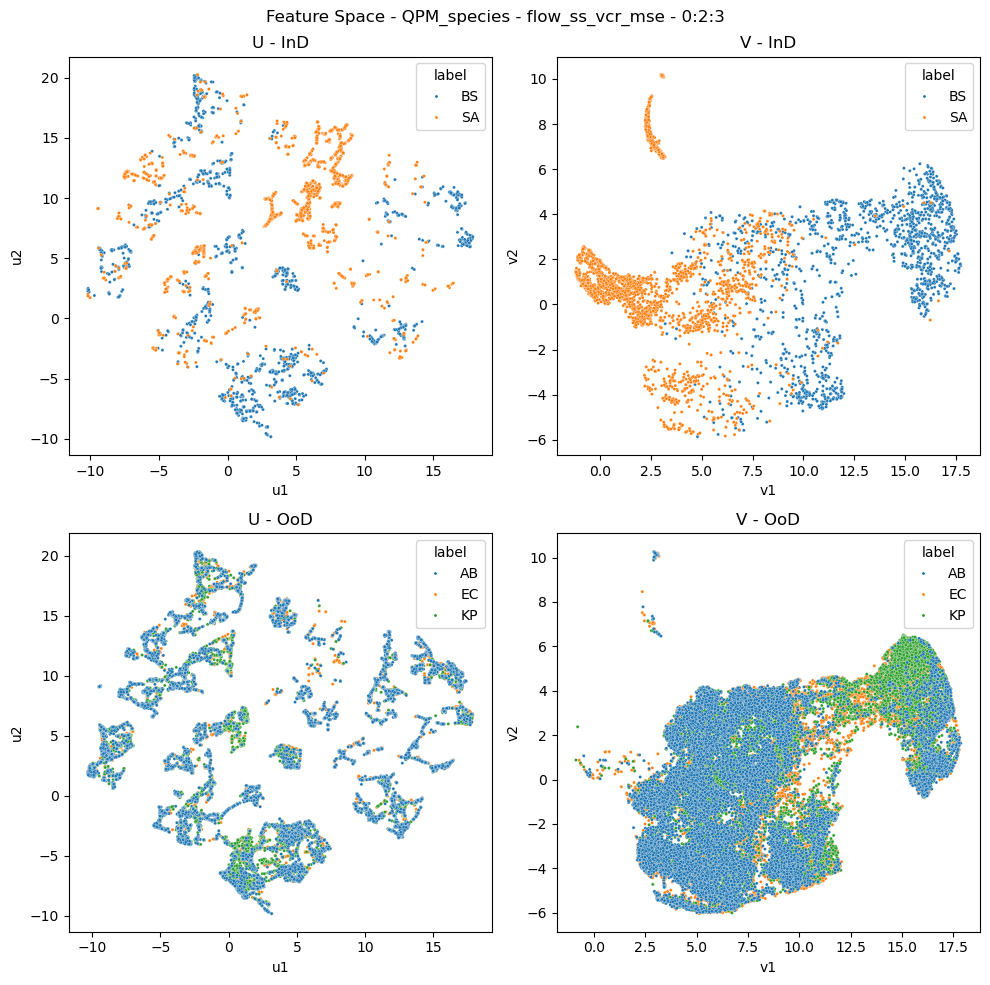

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

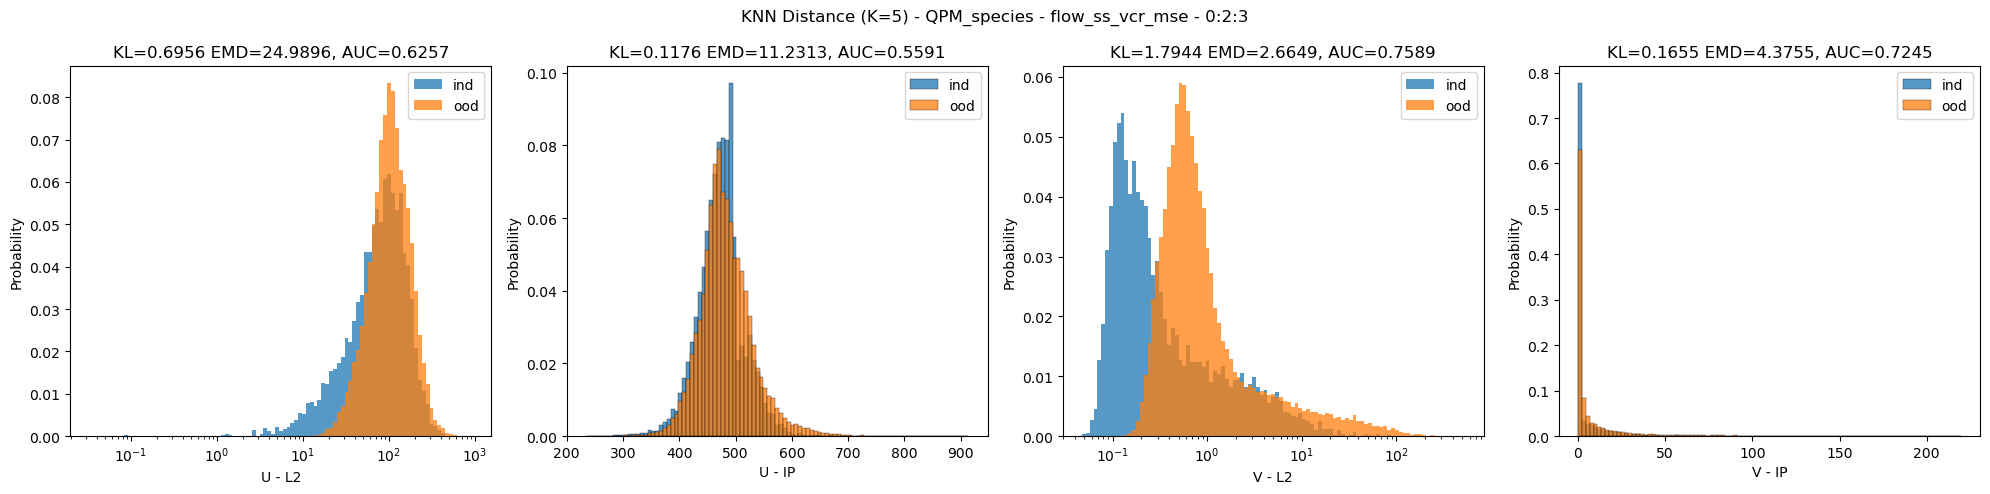

In [13]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

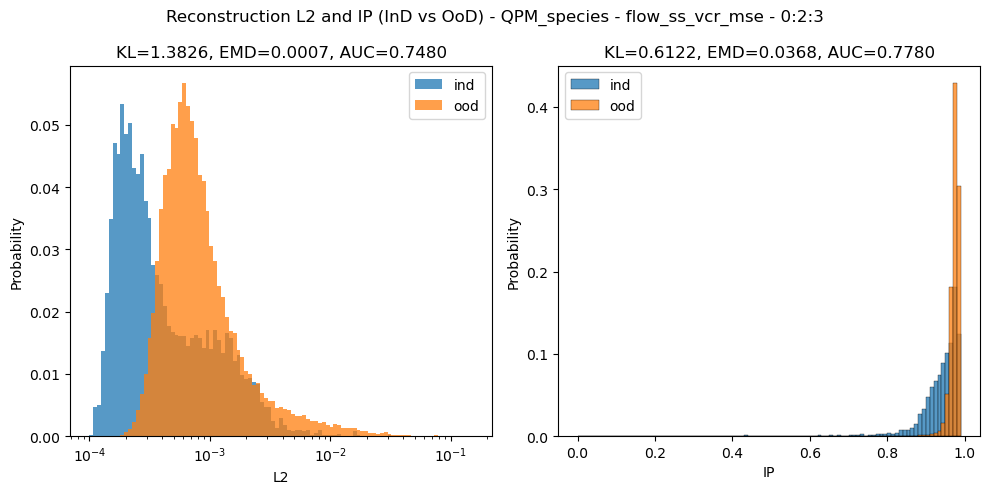

In [14]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_inp.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_inp.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.743055 0.7650029 1.2581391 1.3692685
22.684193 0.6822756 1.1462799 1.2093445
22.750027 0.7551634 1.2786431 1.3675613
23.255346 1.2497305 2.0060554 2.2396302
34.56032 0.92047364 58.11449 0.7491844


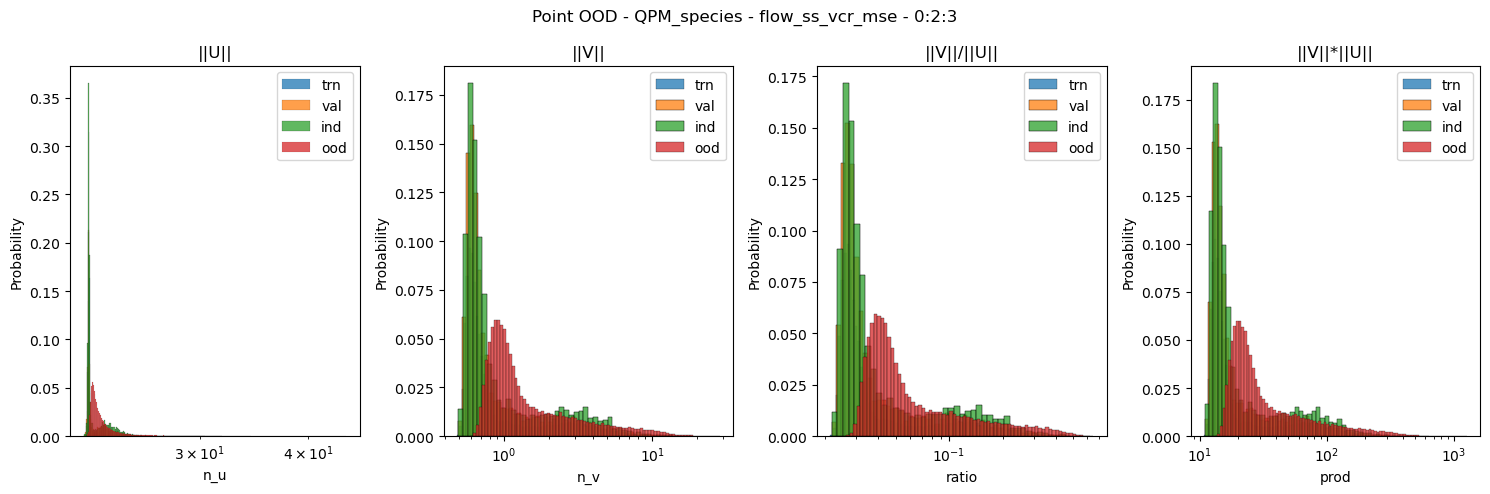

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


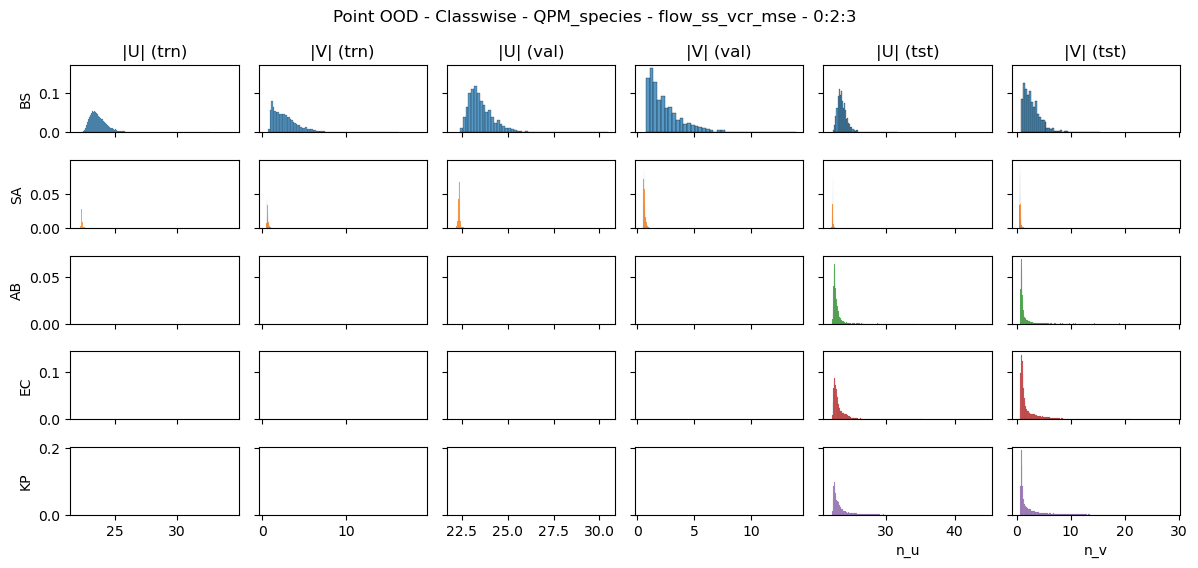

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

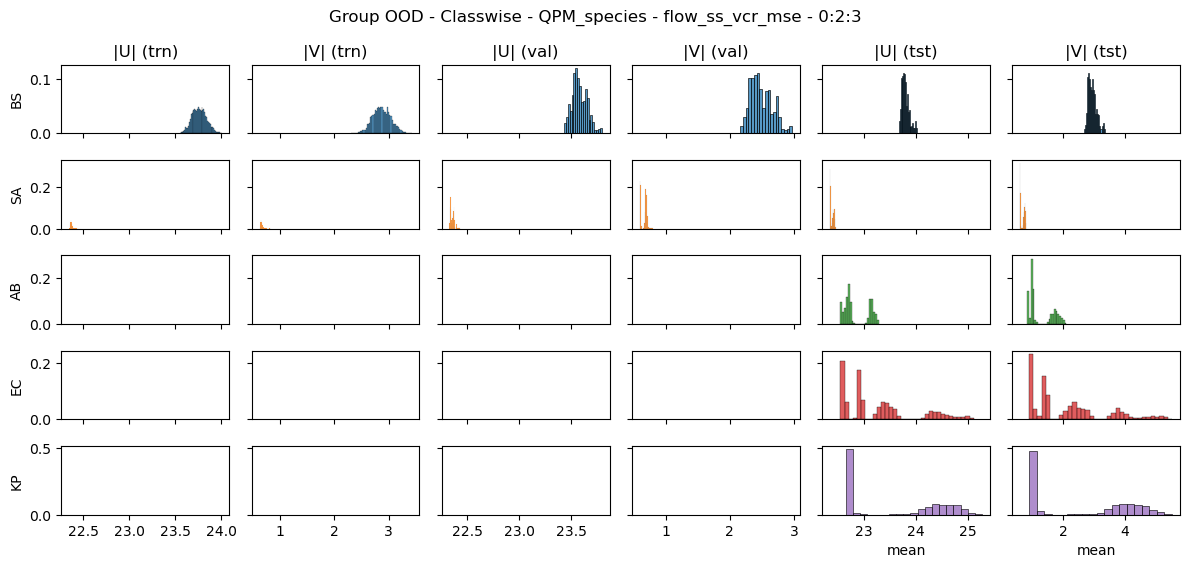

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()